In [1]:
import pandas as pd

file_path = r'C:\Users\glawi\OneDrive - Aston University\Dissertation\jupyter file\household_power_consumption.txt'

df = pd.read_csv(file_path, sep=';', 
                 parse_dates={'Datetime': ['Date', 'Time']},  # Combine Date and Time into a single column
                 dayfirst=True,  # Specify that day comes first in the date
                 na_values=['?'],  # Handle missing values represented as '?'
                 low_memory=False)  # Disable low_memory mode to avoid dtype issues


print(df.head())


             Datetime  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16 17:24:00                4.216                  0.418   234.84   
1 2006-12-16 17:25:00                5.360                  0.436   233.63   
2 2006-12-16 17:26:00                5.374                  0.498   233.29   
3 2006-12-16 17:27:00                5.388                  0.502   233.74   
4 2006-12-16 17:28:00                3.666                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  
0              18.4             0.0             1.0            17.0  
1              23.0             0.0             1.0            16.0  
2              23.0             0.0             2.0            17.0  
3              23.0             0.0             1.0            17.0  
4              15.8             0.0             1.0            17.0  


In [2]:
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# Filling in the missing values with the median
df.fillna(df.median(), inplace=True)

# Converting the data types for numeric columns
df[['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']] = df[['Global_active_power', 
    'Global_reactive_power', 'Voltage', 'Global_intensity', 
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].astype(float)

# Creating time-based features
df['Year'] = df['Datetime'].dt.year
df['Month'] = df['Datetime'].dt.month
df['Day'] = df['Datetime'].dt.day
df['Hour'] = df['Datetime'].dt.hour
df['Day_of_week'] = df['Datetime'].dt.dayofweek

# Resampling to hourly data
df_hourly = df.resample('H', on='Datetime').mean()

from sklearn.preprocessing import MinMaxScaler

# Normalizing the data
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_hourly), columns=df_hourly.columns, index=df_hourly.index)

# Feature engineering: Creating lag features and rolling statistics
df_scaled['lag_1'] = df_scaled['Global_active_power'].shift(1)
df_scaled['lag_24'] = df_scaled['Global_active_power'].shift(24)  # Lag of 24 hours (1 day)
df_scaled['lag_168'] = df_scaled['Global_active_power'].shift(168)  # Lag of 168 hours (1 week)
df_scaled['rolling_mean_24'] = df_scaled['Global_active_power'].rolling(window=24).mean()
df_scaled['rolling_std_24'] = df_scaled['Global_active_power'].rolling(window=24).std()

# Droping NaN values caused by lag and rolling calculations to clean the data for modeling
df_scaled.dropna(inplace=True)

# Defining the features (X) and target variable (y) for the model
X = df_scaled.drop(columns=['Global_active_power'])
y = df_scaled['Global_active_power']

# Spliting the data into training and testing sets to evaluate the model's performance
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)


Missing values in each column:
 Datetime                     0
Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64


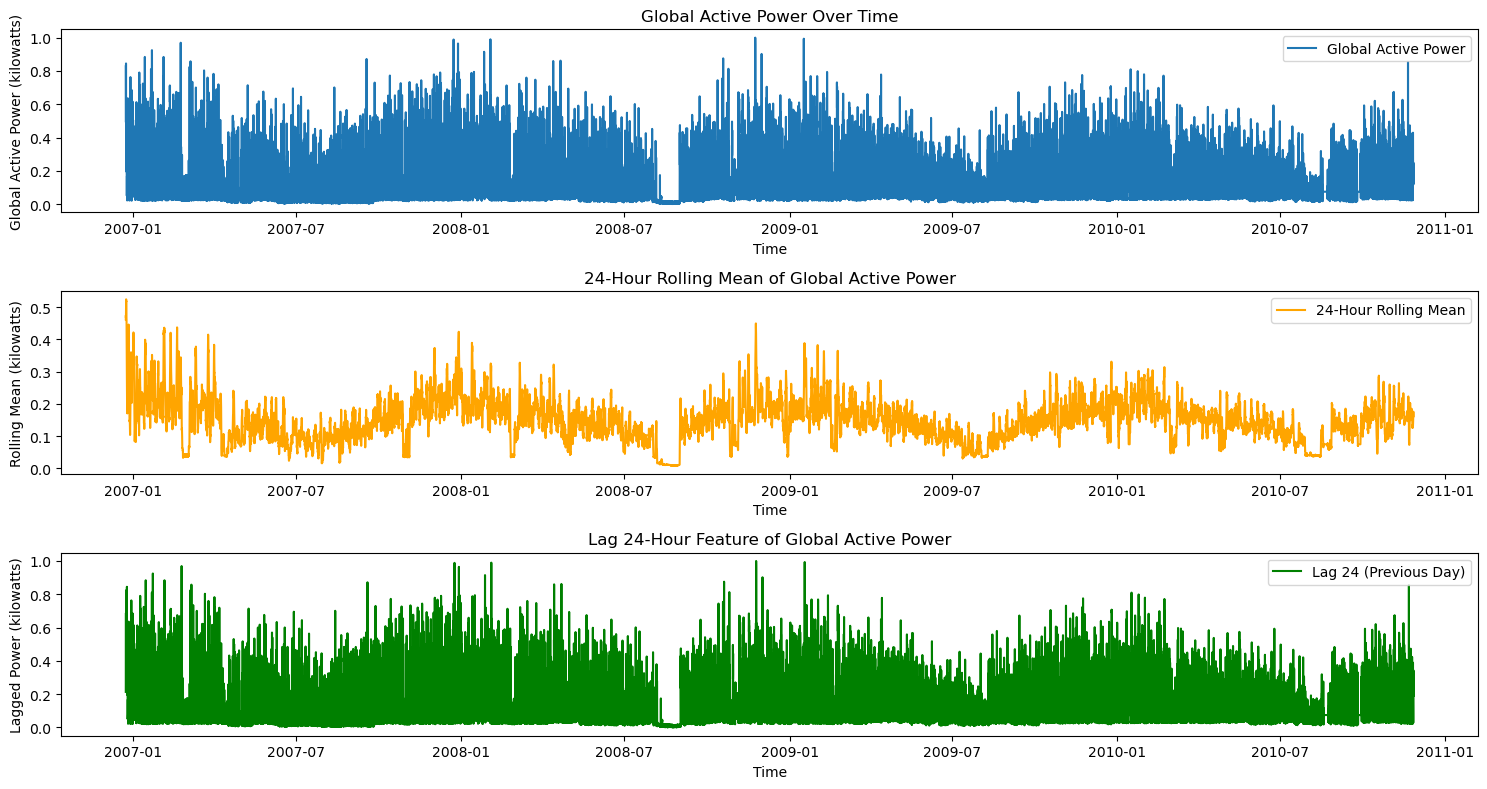

In [3]:
# Visualizing the processed data to better understand the trends and patterns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))

# Ploting Global Active Power
plt.subplot(3, 1, 1)
plt.plot(df_scaled.index, df_scaled['Global_active_power'], label='Global Active Power')
plt.title('Global Active Power Over Time')
plt.xlabel('Time')
plt.ylabel('Global Active Power (kilowatts)')
plt.legend()

# Ploting Rolling Mean
plt.subplot(3, 1, 2)
plt.plot(df_scaled.index, df_scaled['rolling_mean_24'], label='24-Hour Rolling Mean', color='orange')
plt.title('24-Hour Rolling Mean of Global Active Power')
plt.xlabel('Time')
plt.ylabel('Rolling Mean (kilowatts)')
plt.legend()

# Ploting Lag Feature
plt.subplot(3, 1, 3)
plt.plot(df_scaled.index, df_scaled['lag_24'], label='Lag 24 (Previous Day)', color='green')
plt.title('Lag 24-Hour Feature of Global Active Power')
plt.xlabel('Time')
plt.ylabel('Lagged Power (kilowatts)')
plt.legend()

plt.tight_layout()
plt.show()


In [4]:
import numpy as np

# Reshaping the data to 3D for CNN-LSTM input (samples, time steps, features)
def reshape_data(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X.iloc[i:(i + time_steps)].values)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24  

X_train_reshaped, y_train_reshaped = reshape_data(X_train, y_train, time_steps)
X_test_reshaped, y_test_reshaped = reshape_data(X_test, y_test, time_steps)

print(f"Training data shape: {X_train_reshaped.shape}")
print(f"Test data shape: {X_test_reshaped.shape}")


Training data shape: (27512, 24, 16)
Test data shape: (6861, 24, 16)


c:\Users\glawi\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0201 - val_loss: 0.0076
Epoch 2/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0119 - val_loss: 0.0070
Epoch 3/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0104 - val_loss: 0.0067
Epoch 4/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0096 - val_loss: 0.0063
Epoch 5/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0094 - val_loss: 0.0061
Epoch 6/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0090 - val_loss: 0.0061
Epoch 7/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 8/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0086 - val_loss: 0.0060
Epoch 9/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0085 - val_loss: 0.0059
Epoch 10/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0086 - val_loss: 0.0059
Epoch 11/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0081 - val_loss: 0.0057
Epoch 12/20
860/860 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

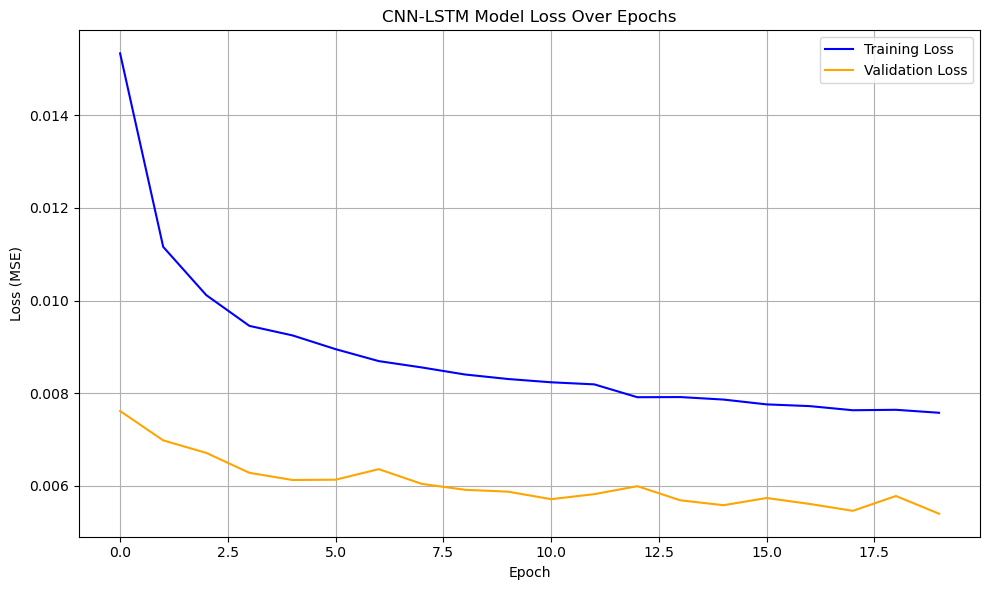

In [5]:
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, Flatten, MaxPooling1D, Dropout

# Building the CNN-LSTM model
model = Sequential()

# 1D Convolutional Layer to extract features
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train_reshaped.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))

# LSTM layer for sequential modeling
model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.2))

# Fully connected output layer
model.add(Dense(1))

# Compiling the model
model.compile(optimizer='adam', loss='mse')

# Training the CNN-LSTM model
history = model.fit(X_train_reshaped, y_train_reshaped, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_reshaped))

# Ploting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('CNN-LSTM Model Loss Over Epochs')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
RMSE: 0.07691861907625269, MAE: 0.05641975960042018


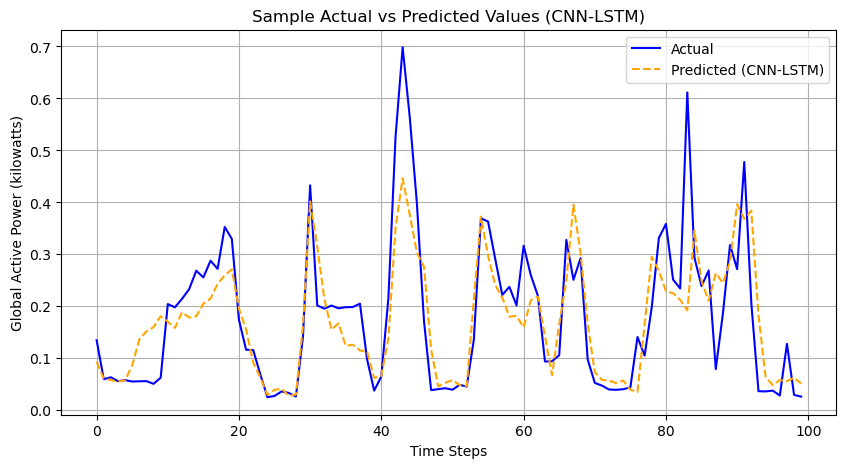

In [8]:
# Separating scalers for features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# Scaling the features (excluding 'Global_active_power')
X_train_scaled = scaler_features.fit_transform(X_train)
X_test_scaled = scaler_features.transform(X_test)

# Scaling the target (only 'Global_active_power')
y_train_scaled = scaler_target.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_target.transform(y_test.values.reshape(-1, 1))

# Reshaping the data again after scaling for CNN-LSTM
X_train_reshaped, y_train_reshaped = reshape_data(pd.DataFrame(X_train_scaled, columns=X_train.columns), pd.Series(y_train_scaled.flatten()), time_steps)
X_test_reshaped, y_test_reshaped = reshape_data(pd.DataFrame(X_test_scaled, columns=X_test.columns), pd.Series(y_test_scaled.flatten()), time_steps)

# Make predictions
y_pred = model.predict(X_test_reshaped)

# Inverse transform the scaled predictions to original scale using the scaler for the target
y_pred_rescaled = scaler_target.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_target.inverse_transform(y_test_reshaped.reshape(-1, 1))

# Calculating RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)

print(f"RMSE: {rmse}, MAE: {mae}")

# Ploting actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[:100], label='Actual', color='blue')
plt.plot(y_pred_rescaled[:100], label='Predicted (CNN-LSTM)', linestyle='dashed', color='orange')
plt.legend()
plt.title("Sample Actual vs Predicted Values (CNN-LSTM)")
plt.xlabel("Time Steps")
plt.ylabel("Global Active Power (kilowatts)")
plt.grid(True)
plt.show()
